In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import pysta
import stc
import stcl
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
folder_name = "data"

#dataset_name = "20180618"
#dataset_name = "20180621"
dataset_name = "20180626"
#dataset_name = "20180828"

stim, spike_train, info = pysta.load_data(dataset_name, folder_name)

info["channel_names"]

dt = 1000/info["sampling_rate"] # in ms

# load cell type
cell_types = pd.read_csv(os.path.join(folder_name, "{}_cell_type.csv".format(dataset_name)))

['dataset_name', 'stim', 'spike_train', 'info']
(64, 9000)
(156, 9000)
{'channel_names': ['12a', '12b', '12c', '13a', '13b', '13c', '13d', '13e', '14a', '14b', '14c', '14d', '16a', '16b', '16c', '17a', '17b', '17c', '17d', '21a', '21b', '21c', '21d', '21e', '22a', '22b', '23a', '23b', '23c', '23d', '25a', '25b', '25c', '26a', '26b', '26c', '26d', '27a', '27b', '27c', '27d', '28a', '28b', '28c', '31a', '31b', '31c', '31d', '32a', '32b', '32c', '33a', '33b', '33c', '33d', '35a', '35b', '35c', '35d', '35e', '35f', '35g', '36a', '36b', '36c', '36d', '37a', '37b', '37c', '37d', '37e', '38a', '41a', '41b', '41c', '41d', '42a', '42b', '42c', '43a', '43b', '43c', '45a', '45b', '45c', '46a', '46b', '47a', '48a', '48b', '48c', '48d', '48e', '51a', '51b', '53a', '53b', '53c', '53d', '54a', '54b', '54c', '54d', '56a', '56b', '58a', '61a', '61b', '62a', '62b', '63a', '63b', '63c', '63d', '63e', '64a', '65a', '65b', '65c', '68a', '68b', '71a', '71b', '71c', '72a', '72b', '72c', '72d', '72e', '73a', 

(64, 9000)


(array([6.659e+03, 1.258e+03, 6.110e+02, 0.000e+00, 3.210e+02, 1.010e+02,
        0.000e+00, 4.100e+01, 8.000e+00, 1.000e+00]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

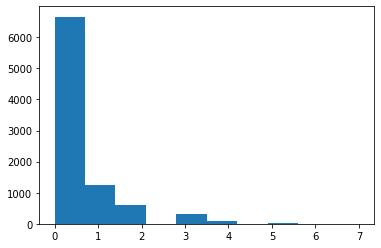

In [66]:
channel_name = "36c" 
ch_idx = pysta.find_channel_index(info["channel_names"], channel_name)

print(stim.shape)

# plt.plot(spike_train[ch_idx])
plt.hist(spike_train[ch_idx])

In [29]:
tap = 8

spike_triggered_stim, spike_count = pysta.grab_spike_triggered_stim(stim, spike_train[ch_idx, :], tap)

print(spike_triggered_stim.shape)
print(spike_count.shape)

spike_triggered_stim = spike_triggered_stim.reshape(spike_count.shape[0],-1)
print(spike_triggered_stim.shape)
print(spike_count.shape)

(2337, 64, 8)
(2337,)
(2337, 512)
(2337,)


In [ ]:
# centering
data_centered = spike_triggered_stim - 0.5
weights = spike_count


10.318830076833994


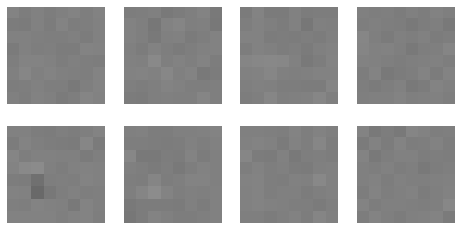

In [77]:
# do STA
sta = np.average(data_centered,weights=weights, axis=0)
pysta.plot_stim_slices(sta, vmin=-0.5, vmax=0.5)

PSNR = pysta.calc_PSNR(sta)
print(PSNR)

In [30]:


# do STC
eig_values, eig_vectors = stc.do_stc(data_centered, weights)

# stcl.plot_temporal_profiles(sta, group_centers, tap, dt)

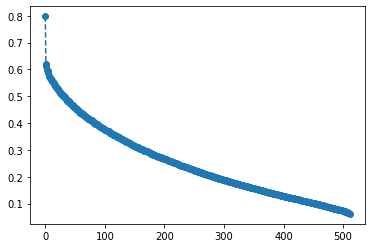

In [32]:
plt.plot(eig_values, 'o--')

In [33]:
# project
projected = stc.project(data_centered, eig_vectors)

projected.shape

(2337, 512)

Text(0, 0.5, 'projection to the 2nd eigenvector')

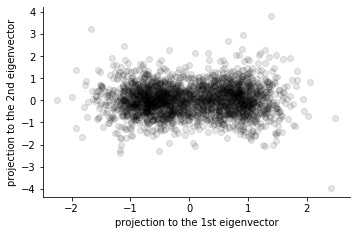

In [49]:
plt.figure(figsize=(5.5,3.5))

plt.scatter(projected[:,0], projected[:,1], alpha=0.1, c='k')

# remove top & right box
# https://stackoverflow.com/a/28720127
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("projection to the 1st eigenvector")
plt.ylabel("projection to the 2nd eigenvector")



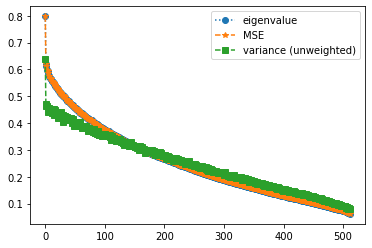

In [64]:
# check variance
variances = list()
mses = list()
for i, eig in enumerate(eig_values):
#     print(eig)
    mses.append(np.average(projected[:,i]**2, weights=weights))
    #mses.append(np.mean(projected[:,i]**2))
    variances.append(np.var(projected[:,i]))  # consider all spikes 0 or 1

mses = np.array(mses)
variances = np.array(variances)

plt.plot(eig_values, 'o:', label='eigenvalue')
plt.plot(mses, '*--', label='MSE')
plt.plot(variances, 's--', label='variance (unweighted)')
plt.legend()

In [68]:
# now do clustering
cluster_dim = 2

cl = stcl.fit(projected[:, :cluster_dim])

pred = cl.predict(projected[:, :cluster_dim])

group_centers = stcl.calc_centers(data_centered, weights, pred)

# calc inner product of two centers
inner_product = np.dot(group_centers[0].ravel(), group_centers[1].ravel())
print(inner_product)

# calc PSNRs for the two centers
PSNR0 = pysta.calc_PSNR(group_centers[0])
PSNR1 = pysta.calc_PSNR(group_centers[1])

print(PSNR0, PSNR1)

-0.555696350420656
18.89251655783109 18.85589553333496


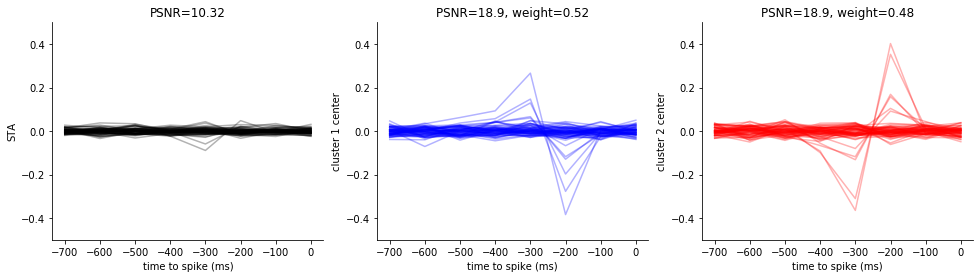

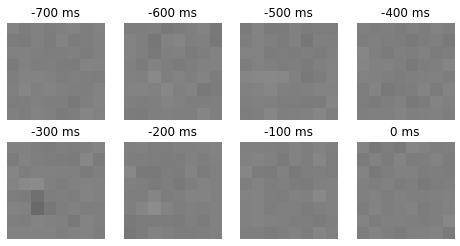

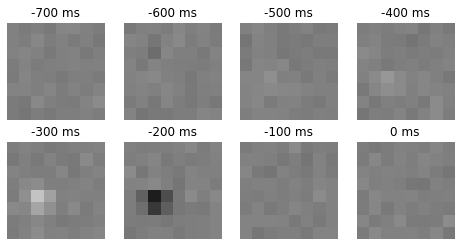

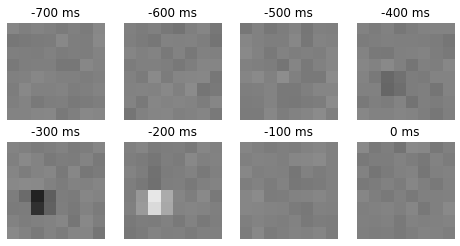

In [102]:
# plot group_centers
folder_name = 'figure'

dt = 100
grid_T = np.linspace(-tap + 1, 0, tap) * dt
stcl.plot_centers(sta, group_centers, grid_T, cl.weights_, PSNR, [PSNR0, PSNR1], vmin=-0.5, vmax=0.5)
plt.savefig(os.path.join(folder_name, "{}_centers.png".format(channel_name)))
plt.savefig(os.path.join(folder_name, "{}_centers.pdf".format(channel_name)))
# plt.close()

pysta.plot_stim_slices(sta, dt=dt, vmin=-0.5, vmax=0.5)
plt.savefig(os.path.join(folder_name, "{}_sta.png".format(channel_name)))
plt.savefig(os.path.join(folder_name, "{}_sta.pdf".format(channel_name)))
# plt.close()

pysta.plot_stim_slices(group_centers[0], dt=dt, vmin=-0.5, vmax=0.5)
plt.savefig(os.path.join(folder_name, "{}_center_1.png".format(channel_name)))
plt.savefig(os.path.join(folder_name, "{}_center_1.pdf".format(channel_name)))
# plt.close()

pysta.plot_stim_slices(group_centers[1], dt=dt, vmin=-0.5, vmax=0.5)
plt.savefig(os.path.join(folder_name, "{}_center_2.png".format(channel_name)))
plt.savefig(os.path.join(folder_name, "{}_center_2.pdf".format(channel_name)))
# plt.close()

In [112]:

# project centers
sta_projected = stc.project(sta, eig_vectors)
group_center0_projected = stc.project(group_centers[0], eig_vectors)
group_center1_projected = stc.project(group_centers[1], eig_vectors)

# projected.shape


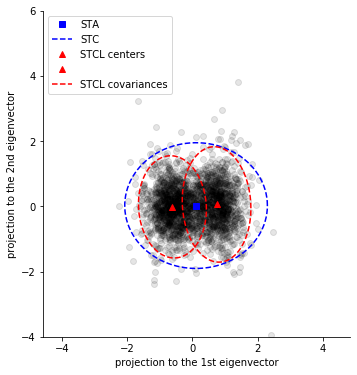

In [175]:
plt.figure(figsize=(5.5,6))

plt.scatter(projected[:,0], projected[:,1], alpha=0.1, c='k')

plt.plot(sta_projected[0], sta_projected[1], 'sb')

# calc cov mat for plotting ellipse
covariance_mat = stc.calc_covariance_matrix(projected[:,:2], weights, centered=True)
pysta.plot_ellipse(sta_projected[:2], covariance_mat, 'b--')

center0 = cl.means_[0]
plt.plot(center0[0], center0[1], '^r')
center1 = cl.means_[1]
plt.plot(center1[0], center1[1], '^r')

# plt.plot(group_center0_projected[0], group_center0_projected[1], '^r')
# plt.plot(group_center1_projected[0], group_center1_projected[1], '^r')

pysta.plot_ellipse(cl.means_[0], cl.covariances_[0])
pysta.plot_ellipse(cl.means_[1], cl.covariances_[1])

# remove top & right box
# https://stackoverflow.com/a/28720127
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("projection to the 1st eigenvector")
plt.ylabel("projection to the 2nd eigenvector")

plt.legend(["STA", "STC", "STCL centers", None, "STCL covariances"]) #, loc="upper left")

plt.axis('equal')
plt.ylim(-4, 6)

plt.savefig(os.path.join('figure', dataset_name + "_" + channel_name + "_projection.pdf"))
plt.savefig(os.path.join('figure', dataset_name + "_" + channel_name + "_projection.png"))


In [125]:
print(cl.means_.shape)
print(cl.means_)
print(cl.covariances_.shape)
print(cl.covariances_)
# cl.covariances_

(2, 2)
[[-0.61291735 -0.01600844]
 [ 0.74025392  0.05852125]]
(2, 2, 2)
[[[ 0.18087829 -0.01421071]
  [-0.01421071  0.41001555]]

 [[ 0.1848045  -0.0208102 ]
  [-0.0208102   0.52257606]]]
